# Classify your YouTube history

## Prepare data

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from preparation import prepare_data
from preprocess import preprocess
from select_by_date_interval import select_by_date_interval

In [2]:
PATH = "C:/Users/San/Documents/CS projects/yt_activity_analysis/data/Takeout/YouTube and YouTube Music/history/watch-history.json"
df = prepare_data(PATH)

start_date = "2023-01-01"
# end_date = "2022-11-01"
df = select_by_date_interval(df, start=start_date)
# df = df.loc[df["app"] == "YouTube Music"] # if you wanna work only with YT Music data
df

,video_title,channel_name,time,app
1,Жбурляю,Харцизи,2023-04-04 14:59:28.805000+03:00,YouTube Music
2,Ліхтар,Rohata Zhaba,2023-04-04 14:25:11.177000+03:00,YouTube
3,Drinker's Chasers - ANOTHER Rey Skywalker Movie?!,Critical Drinker After Hours,2023-04-04 14:12:17.193000+03:00,YouTube
4,Test Your English Vocabulary: SHAPES & PATTERNS,Learn English with Gill · engVid,2023-04-04 14:06:00.179000+03:00,YouTube
5,Finland joins NATO in historic shift prompted ...,FRANCE 24 English,2023-04-04 14:02:41.452000+03:00,YouTube
...,...,...,...,...
4391,Assassin's Creed Odyssey - Before You Buy,gameranx,2023-01-01 10:02:05.355000+02:00,YouTube
4392,#Ukraine's spy chief tells ABC News there will...,ABC News,2023-01-01 09:44:58.841000+02:00,YouTube
4393,Russian missile zooms over Kyiv before being s...,The Sun,2023-01-01 09:43:07.927000+02:00,YouTube
4394,YARMAK FT. TOF - МОЯ КРАЇНА,Yarmak Music,2023-01-01 00:07:14.838000+02:00,YouTube


### Classification approach

In order to categorize my YouTube watch history, I employ a combination of a simple rule-based approach and machine learning classification.

The videos are divided into five categories: 
- 'Music'
- 'Rec' (including games, movies, fictional books, and other not-so-productive content)
- 'Studies' (covering subjects like English, math, computer science, non-fictional books, and other educational material)
- 'Politics' (including war, inner politics, news, and related topics)
- 'Sport' (mainly follow-along workouts)

By assigning each video to one of these categories, I'll be able to better organize and understand my watch history.

Classification flow: 

1. First, examine the 'app' column in the dataframe to determine the source of the video ('YouTube' or 'YouTube Music').

2. If the 'app' value is 'YouTube Music', assign the video to the 'Music' category.

3. Handle songs listened to in the YouTube app (NOT YouTube Music app) by checking if the 'video_title' or 'channel_name' exists in rows already classified as 'Music'.

4. Work with videos that are not songs by combining the 'video_title' and 'channel_name' into a new column called 'combined_preprocess' and preprocessing the data.

5. Divide the dataframe based on whether the 'combined_preprocess' column has four or more characters.

6. For rows with fewer than four characters, check if they are already classified as 'Music'. If not, label them as 'Politics'.

7. Put the rows with four or more characters through the machine learning model.

Let's start with deciding whether the video is a song or not

In [46]:
df["app"].value_counts()

YouTube          2507
YouTube Music    1888
Name: app, dtype: int64

In [3]:
def if_YT_Music(row):
    if row["app"] == "YouTube Music":
        category = "Music"
    else:
        category = "Not Music"
    return category

def if_in_YT_Music(row):
    # if the channel_name or video_title were encountered in
    # YT Music app before, assign "Music" category to the video
    category = row["category"]
    if row["category"] == "Not Music":
        if row["channel_name"] in music_df["channel_name"].values:
            category = "Music"
        elif row["video_title"] in music_df["video_title"].values:
            category = "Music"
    return category

df["category"] = df.apply(if_YT_Music, axis=1)
music_df = df.loc[df["app"] == "YouTube Music"]
df["category"] = df.apply(if_in_YT_Music, axis=1)
df.head(3)

,video_title,channel_name,time,app,category
1,Жбурляю,Харцизи,2023-04-04 14:59:28.805000+03:00,YouTube Music,Music
2,Ліхтар,Rohata Zhaba,2023-04-04 14:25:11.177000+03:00,YouTube,Not Music
3,Drinker's Chasers - ANOTHER Rey Skywalker Movie?!,Critical Drinker After Hours,2023-04-04 14:12:17.193000+03:00,YouTube,Not Music


Well, with several rules (that is a Rule-based system or smt), I got 129 more videos classified as songs. However, there are game/movie soundtrack collections classified as 'Not Music'

In [48]:
df["category"].value_counts()

Not Music    2378
Music        2017
Name: category, dtype: int64

In [4]:
df["preproc"] = df["video_title"].apply(preprocess)
# if we have print 'preproc' col, we'll see that non-english text is not properly handled
# After several failed attempts at handling non-english text, it was decided to drop rows
# where 'preproc' col has fewer than 4 chars
print(f"Before dropping: {len(df)}")
empty_rows = df[df['preproc'].str.len() < 4]
df = df[df['preproc'].str.len() >= 4]
print(f"After: {len(df)}")
df.head(3)

Before dropping: 4395
After: 3404


,video_title,channel_name,time,app,category,preproc
3,Drinker's Chasers - ANOTHER Rey Skywalker Movie?!,Critical Drinker After Hours,2023-04-04 14:12:17.193000+03:00,YouTube,Not Music,drinkers chasers another rey skywalker movie
4,Test Your English Vocabulary: SHAPES & PATTERNS,Learn English with Gill · engVid,2023-04-04 14:06:00.179000+03:00,YouTube,Not Music,test english vocabulary shapes patterns
5,Finland joins NATO in historic shift prompted ...,FRANCE 24 English,2023-04-04 14:02:41.452000+03:00,YouTube,Not Music,finland joins nato historic shift prompted ukr...


In [6]:
empty_rows.head(3)

,video_title,channel_name,time,app,category,preproc
1,Жбурляю,Харцизи,2023-04-04 14:59:28.805000+03:00,YouTube Music,Music,
2,Ліхтар,Rohata Zhaba,2023-04-04 14:25:11.177000+03:00,YouTube,Not Music,
9,Мавка,Authentix,2023-04-04 12:57:54.594000+03:00,YouTube,Not Music,


In [8]:
empty_rows["combined"] = empty_rows["video_title"] + " " + empty_rows["channel_name"]
empty_rows["combined_preproc"] = empty_rows["combined"].apply(preprocess)
empty_rows.head()

C:\Windows\Temp\ipykernel_15928\2677169761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_rows["combined"] = empty_rows["video_title"] + " " + empty_rows["channel_name"]
C:\Windows\Temp\ipykernel_15928\2677169761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empty_rows["combined_preproc"] = empty_rows["combined"].apply(preprocess)


,video_title,channel_name,time,app,category,preproc,combined,combined_preproc
1,Жбурляю,Харцизи,2023-04-04 14:59:28.805000+03:00,YouTube Music,Music,,Жбурляю Харцизи,
2,Ліхтар,Rohata Zhaba,2023-04-04 14:25:11.177000+03:00,YouTube,Not Music,,Ліхтар Rohata Zhaba,rohata zhaba
9,Мавка,Authentix,2023-04-04 12:57:54.594000+03:00,YouTube,Not Music,,Мавка Authentix,authentix
10,Харцизи - Забуті боги,Харцизи,2023-04-04 12:50:32.692000+03:00,YouTube,Music,,Харцизи - Забуті боги Харцизи,
13,Злива,Харцизи,2023-04-04 12:44:35.400000+03:00,YouTube,Music,,Злива Харцизи,


In [10]:
len(empty_rows[empty_rows['combined_preproc'].str.len() >= 4])

610

In [26]:
sec_failure = empty_rows[empty_rows['combined_preproc'].str.len() < 4].drop(["preproc"], axis=1)
sec_failure

,video_title,channel_name,time,app,category,combined,combined_preproc
1,Жбурляю,Харцизи,2023-04-04 14:59:28.805000+03:00,YouTube Music,Music,Жбурляю Харцизи,
10,Харцизи - Забуті боги,Харцизи,2023-04-04 12:50:32.692000+03:00,YouTube,Music,Харцизи - Забуті боги Харцизи,
13,Злива,Харцизи,2023-04-04 12:44:35.400000+03:00,YouTube,Music,Злива Харцизи,
14,На самоті,Харцизи,2023-04-04 12:41:26.109000+03:00,YouTube,Music,На самоті Харцизи,
15,Глибоке небо,Харцизи,2023-04-04 12:37:56.562000+03:00,YouTube,Music,Глибоке небо Харцизи,
...,...,...,...,...,...,...,...
4173,"Консерваторія чи ""консерва"" імені Чайковського...",ШОУБІСИКИ,2023-01-04 23:28:24.540000+02:00,YouTube,Not Music,"Консерваторія чи ""консерва"" імені Чайковського...",
4238,Ніколи? Знову!,ХАС,2023-01-04 09:25:02.756000+02:00,YouTube Music,Music,Ніколи? Знову! ХАС,
4251,Ніколи? Знову!,ХАС,2023-01-03 18:00:17.111000+02:00,YouTube Music,Music,Ніколи? Знову! ХАС,
4310,Сухпай Збройних сил Республіки Корея 한국군 배급,ХЛОПЦІ З ЛІСУ,2023-01-02 21:39:10.283000+02:00,YouTube,Not Music,Сухпай Збройних сил Республіки Корея 한국군 배급 ХЛ...,


In [27]:
sec_failure["category"].value_counts()

Not Music    270
Music        111
Name: category, dtype: int64

In [29]:
sec_failure.to_csv("381_rows_2nd_preproc_failure.csv")

In [30]:
sec_failure["channel_name"].value_counts()

Цензор.НЕТ          62
Харцизи             46
ШОУБІСИКИ           36
Тартак              28
ХАС                 28
                    ..
Дети Фристайла       1
АНТИТІЛА             1
Андрій Павленко      1
Конь в пальто        1
Сметанин Василий     1
Name: channel_name, Length: 69, dtype: Int64

From those 381 rows, 1/3 is music, and the rest is mostly relating to 'Politics' category with tiny bit connected to 'Rec' category

In [13]:
new = empty_rows[empty_rows['combined_preproc'].str.len() >= 4].drop(["preproc"], axis=1)
new

,video_title,channel_name,time,app,category,combined,combined_preproc
2,Ліхтар,Rohata Zhaba,2023-04-04 14:25:11.177000+03:00,YouTube,Not Music,Ліхтар Rohata Zhaba,rohata zhaba
9,Мавка,Authentix,2023-04-04 12:57:54.594000+03:00,YouTube,Not Music,Мавка Authentix,authentix
23,Фортеця Бахмут,Antytila,2023-04-04 11:52:49.239000+03:00,YouTube Music,Music,Фортеця Бахмут Antytila,antytila
29,ВЛАДЛЕН ТАТАРСЬКИЙ ЗАЖМУРИВСЯ - ОЛДСКУЛЬНИЙ РО...,Old School,2023-04-03 23:42:34.126000+03:00,YouTube,Not Music,ВЛАДЛЕН ТАТАРСЬКИЙ ЗАЖМУРИВСЯ - ОЛДСКУЛЬНИЙ РО...,old school
50,"""Ось наші Леопарди!"": танкісти і піхота 92-ї О...",BIHUS Info,2023-04-03 22:03:11.147000+03:00,YouTube,Not Music,"""Ось наші Леопарди!"": танкісти і піхота 92-ї О...",92 bihus info
...,...,...,...,...,...,...,...
4250,Силуети,SadSvit,2023-01-03 18:03:09.811000+02:00,YouTube Music,Music,Силуети SadSvit,sadsvit
4256,#КОЗАЦЬКОМУ_РОДУ,Jerry Heil,2023-01-03 17:34:33.059000+02:00,YouTube Music,Music,#КОЗАЦЬКОМУ_РОДУ Jerry Heil,jerry heil
4257,"Тихо прийшов, тихо пішов або пісня спеціальног...",Riffmaster,2023-01-03 17:29:21.578000+02:00,YouTube Music,Music,"Тихо прийшов, тихо пішов або пісня спеціальног...",riffmaster
4346,Як військові відреагували на звернення Зеленсь...,Ukrainian Witness,2023-01-02 08:53:54.148000+02:00,YouTube,Not Music,Як військові відреагували на звернення Зеленсь...,ukrainian witness


In [16]:
new["category"].value_counts()

Music        477
Not Music    133
Name: category, dtype: int64

In [14]:
# new.to_csv("610_additional.csv")

In [18]:
maj_ua_610 = pd.read_csv("610_additional.csv", index_col=0)
maj_ua_610

,video_title,channel_name,time,app,category,combined,combined_preproc
2,Ліхтар,Rohata Zhaba,2023-04-04 14:25:11.177000+03:00,YouTube,Music,Ліхтар Rohata Zhaba,rohata zhaba
9,Мавка,Authentix,2023-04-04 12:57:54.594000+03:00,YouTube,Music,Мавка Authentix,authentix
23,Фортеця Бахмут,Antytila,2023-04-04 11:52:49.239000+03:00,YouTube Music,Music,Фортеця Бахмут Antytila,antytila
29,ВЛАДЛЕН ТАТАРСЬКИЙ ЗАЖМУРИВСЯ - ОЛДСКУЛЬНИЙ РО...,Old School,2023-04-03 23:42:34.126000+03:00,YouTube,Politics,ВЛАДЛЕН ТАТАРСЬКИЙ ЗАЖМУРИВСЯ - ОЛДСКУЛЬНИЙ РО...,old school
50,"""Ось наші Леопарди!"": танкісти і піхота 92-ї О...",BIHUS Info,2023-04-03 22:03:11.147000+03:00,YouTube,Politics,"""Ось наші Леопарди!"": танкісти і піхота 92-ї О...",92 bihus info
...,...,...,...,...,...,...,...
4250,Силуети,SadSvit,2023-01-03 18:03:09.811000+02:00,YouTube Music,Music,Силуети SadSvit,sadsvit
4256,#КОЗАЦЬКОМУ_РОДУ,Jerry Heil,2023-01-03 17:34:33.059000+02:00,YouTube Music,Music,#КОЗАЦЬКОМУ_РОДУ Jerry Heil,jerry heil
4257,"Тихо прийшов, тихо пішов або пісня спеціальног...",Riffmaster,2023-01-03 17:29:21.578000+02:00,YouTube Music,Music,"Тихо прийшов, тихо пішов або пісня спеціальног...",riffmaster
4346,Як військові відреагували на звернення Зеленсь...,Ukrainian Witness,2023-01-02 08:53:54.148000+02:00,YouTube,Politics,Як військові відреагували на звернення Зеленсь...,ukrainian witness


In [20]:
maj_ua_610["category"].value_counts()

Music       497
Politics     86
Rec          23
Studies       3
Sport         1
Name: category, dtype: int64

In [21]:
maj_ua_610["category"].value_counts(normalize=True)

Music       0.814754
Politics    0.140984
Rec         0.037705
Studies     0.004918
Sport       0.001639
Name: category, dtype: float64

In [25]:
df["category"].value_counts()

Music       497
Rec         195
Politics    158
Studies     120
Sport        30
Name: category, dtype: int64

In [24]:
df["category"].value_counts(normalize=True)

Music       0.497
Rec         0.195
Politics    0.158
Studies     0.120
Sport       0.030
Name: category, dtype: float64

In [11]:
len(empty_rows[empty_rows['combined_preproc'].str.len() < 4])

381

Without combining 'video_title' and 'channel_name' cols, we lose 991 rows. Let's see how many rows we're gonna lose when these cols are combined

In [62]:
df["combined"] = df["video_title"] + " " + df["channel_name"]
df["combined_preproc"] = df["combined"].apply(preprocess)
df.head(3)

,video_title,channel_name,time,app,category,combined,combined_preproc
1,Жбурляю,Харцизи,2023-04-04 14:59:28.805000+03:00,YouTube Music,Music,Жбурляю Харцизи,
2,Ліхтар,Rohata Zhaba,2023-04-04 14:25:11.177000+03:00,YouTube,Not Music,Ліхтар Rohata Zhaba,rohata zhaba
3,Drinker's Chasers - ANOTHER Rey Skywalker Movie?!,Critical Drinker After Hours,2023-04-04 14:12:17.193000+03:00,YouTube,Not Music,Drinker's Chasers - ANOTHER Rey Skywalker Movie?! Critical Drinker After Hours,drinkers chasers another rey skywalker movie critical drinker hours


In [63]:
print(f"Before dropping: {len(df)}")
df = df[df['combined_preproc'].str.len() >= 4]
print(f"After: {len(df)}")

Before dropping: 4395
After: 4014


In [65]:
# df.to_csv("unlabeled_combined_len_4014.csv")

As you can see, if we combine those two cols, we lose significantly fewer rows. Only 381 to be precise

# Okay, let's add those 610 rows on top of the 1000 elem sample

In [11]:
additional_610 = pd.read_csv("610_additional.csv", index_col=0)
additional_610.head(3)

,video_title,channel_name,time,app,category,combined,combined_preproc
2,Ліхтар,Rohata Zhaba,2023-04-04 14:25:11.177000+03:00,YouTube,Music,Ліхтар Rohata Zhaba,rohata zhaba
9,Мавка,Authentix,2023-04-04 12:57:54.594000+03:00,YouTube,Music,Мавка Authentix,authentix
23,Фортеця Бахмут,Antytila,2023-04-04 11:52:49.239000+03:00,YouTube Music,Music,Фортеця Бахмут Antytila,antytila


In [14]:
df = df.drop(["preproc"], axis=1)
df.head(3)

,video_title,channel_name,app,category,time,combined,combined_preproc
0,YARMAK FT. TOF - МОЯ КРАЇНА,Yarmak Music,YouTube,Music,2023-01-01 00:07:14.838000+02:00,YARMAK FT. TOF - МОЯ КРАЇНА Yarmak Music,yarmak ft tof yarmak music
1,Russian missile zooms over Kyiv before being s...,The Sun,YouTube,Politics,2023-01-01 09:43:07.927000+02:00,Russian missile zooms over Kyiv before being s...,russian missile zooms kyiv shot time sun
2,Pathfinder: Kingmaker Review,MandaloreGaming,YouTube,Rec,2023-01-01 10:15:11.845000+02:00,Pathfinder: Kingmaker Review MandaloreGaming,pathfinder kingmaker review mandaloregaming


In [19]:
df_combined_1610_sample = pd.concat([df, additional_610])
df_combined_1610_sample = df_combined_1610_sample.sort_values(
    by='time', ascending=True, ignore_index=True)
df_combined_1610_sample

,video_title,channel_name,app,category,time,combined,combined_preproc
0,Гімн України,Oleksandr Ponomariov,YouTube,Music,2023-01-01 00:06:19.680000+02:00,Гімн України Oleksandr Ponomariov,oleksandr ponomariov
1,YARMAK FT. TOF - МОЯ КРАЇНА,Yarmak Music,YouTube,Music,2023-01-01 00:07:14.838000+02:00,YARMAK FT. TOF - МОЯ КРАЇНА Yarmak Music,yarmak ft tof yarmak music
2,Russian missile zooms over Kyiv before being s...,The Sun,YouTube,Politics,2023-01-01 09:43:07.927000+02:00,Russian missile zooms over Kyiv before being s...,russian missile zooms kyiv shot time sun
3,Pathfinder: Kingmaker Review,MandaloreGaming,YouTube,Rec,2023-01-01 10:15:11.845000+02:00,Pathfinder: Kingmaker Review MandaloreGaming,pathfinder kingmaker review mandaloregaming
4,Homeworld: Deserts of Kharak Review,MandaloreGaming,YouTube,Rec,2023-01-01 10:16:11.299000+02:00,Homeworld: Deserts of Kharak Review MandaloreG...,homeworld deserts kharak review mandaloregaming
...,...,...,...,...,...,...,...
1605,Фортеця Бахмут,Antytila,YouTube Music,Music,2023-04-04 11:52:49.239000+03:00,Фортеця Бахмут Antytila,antytila
1606,Deep Rock Galactic - 5th Anniversary Space Rig...,Thai,YouTube,Music,2023-04-04 12:47:36.411000+03:00,Deep Rock Galactic - 5th Anniversary Space Rig...,deep rock galactic 5th anniversary space rig m...
1607,Мавка,Authentix,YouTube,Music,2023-04-04 12:57:54.594000+03:00,Мавка Authentix,authentix
1608,Drinker's Chasers - ANOTHER Rey Skywalker Movie?!,Critical Drinker After Hours,YouTube,Rec,2023-04-04 14:12:17.193000+03:00,Drinker's Chasers - ANOTHER Rey Skywalker Movi...,drinkers chasers another rey skywalker movie c...


In [16]:
df_combined_1610_sample["category"].value_counts()

Music       994
Politics    244
Rec         218
Studies     123
Sport        31
Name: category, dtype: int64

In [20]:
# df_combined_1610_sample.to_csv("labeled_sample_1610_elem.csv")

# CLASSIFICATION WITH ALREADY PREPARED SAMPLE

In [2]:
df = pd.read_csv('data/samples/labeled_sample_1610_elem.csv', index_col=0)
df.tail(3)

,video_title,channel_name,app,category,time,combined,combined_preproc
1607,Мавка,Authentix,YouTube,Music,2023-04-04 12:57:54.594000+03:00,Мавка Authentix,authentix
1608,Drinker's Chasers - ANOTHER Rey Skywalker Movie?!,Critical Drinker After Hours,YouTube,Rec,2023-04-04 14:12:17.193000+03:00,Drinker's Chasers - ANOTHER Rey Skywalker Movi...,drinkers chasers another rey skywalker movie c...
1609,Ліхтар,Rohata Zhaba,YouTube,Music,2023-04-04 14:25:11.177000+03:00,Ліхтар Rohata Zhaba,rohata zhaba


Let's think about possible categories:
- music - it's the easiest one because I can do it without any classification algo by treating every video in YouTube Music as a song. However, you'll need to handle songs you listened in YouTube app. Maybe just check if video_title or channel_name happened already in YouTube Music. If so, then it's a song as well
- entertainment - games, movies, books, and other not so productive stuff
- enlightment/learning - english, math, cs, books, and other subjects
- politics - war, inner policies, and so on

However, what if some videos combine different categories? For example, a history video can be both entertaining and enlightning

In [3]:
# df['target_label'] = pd.factorize(df['category'])[0]
df["target_label"] = df["category"].map({
    "Music": 0,
    "Rec": 1,
    "Politics": 2,
    "Studies": 3,
    "Sport": 4
})

At last, time for classification

In [4]:
from sklearn.model_selection import train_test_split

train_corpus, test_corpus, train_label_nums, test_label_nums, train_label_names, test_label_names = train_test_split(
    np.array(df['combined_preproc']), np.array(df['target_label']), np.array(df['category']), test_size=0.2, random_state=0)
train_corpus.shape, test_corpus.shape

((1288,), (322,))

In [5]:
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(min_df=0., max_df=1., norm='l2', use_idf=True, smooth_idf=True)
tv_train_features = tv.fit_transform(train_corpus)
tv_test_features = tv.transform(test_corpus)

In [6]:
from sklearn.svm import LinearSVC
svm = LinearSVC(penalty='l2', C=1, random_state=0)
svm.fit(tv_train_features, train_label_names)
svm_bow_tv_scores = cross_val_score(svm, tv_train_features, train_label_names, cv=5)
svm_bow_tv_mean_score = np.mean(svm_bow_tv_scores)

print('CV Accuracy (5-fold):', svm_bow_tv_scores)
print('Mean CV Accuracy:', svm_bow_tv_mean_score)
svm_bow_test_score = svm.score(tv_test_features, test_label_names)
print('Test Accuracy:', svm_bow_test_score)

CV Accuracy (5-fold): [0.87596899 0.89922481 0.90697674 0.88326848 0.91439689]
Mean CV Accuracy: 0.895967182457093
Test Accuracy: 0.8850931677018633


Accuracy: The overall correctness of the model's predictions, calculated as (TP + TN) / (TP + TN + FP + FN).

Precision: The proportion of correctly predicted positive instances out of all instances predicted as positive, calculated as TP / (TP + FP).

Recall (Sensitivity or True Positive Rate): The proportion of correctly predicted positive instances out of all actual positive instances, calculated as TP / (TP + FN).

F1 Score: The harmonic mean of precision and recall, which provides a balanced measure of the model's accuracy, calculated as 2 * (Precision * Recall) / (Precision + Recall).

In [7]:
from sklearn.metrics import classification_report
# predict labels for the test set
svm_predictions = svm.predict(tv_test_features)
# hardcode the unique classes order because I'm sick of the constant shifting of rows
# unique_classes = list(set(test_label_names))
unique_classes = ["Politics", "Studies", "Sport", "Music", "Rec"]
# print the classification report
print(classification_report(test_label_names, svm_predictions, labels=unique_classes))

              precision    recall  f1-score   support

    Politics       0.80      0.87      0.83        52
     Studies       0.77      0.59      0.67        34
       Sport       1.00      0.71      0.83         7
       Music       0.93      0.97      0.95       188
         Rec       0.84      0.78      0.81        41

    accuracy                           0.89       322
   macro avg       0.87      0.78      0.82       322
weighted avg       0.88      0.89      0.88       322



In [8]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(
    test_label_names, svm_predictions, labels=unique_classes)
print("Confusion Matrix")
print(conf_matrix)

Confusion Matrix
[[ 45   2   0   4   1]
 [  9  20   0   3   2]
 [  1   0   5   1   0]
 [  1   1   0 183   3]
 [  0   3   0   6  32]]


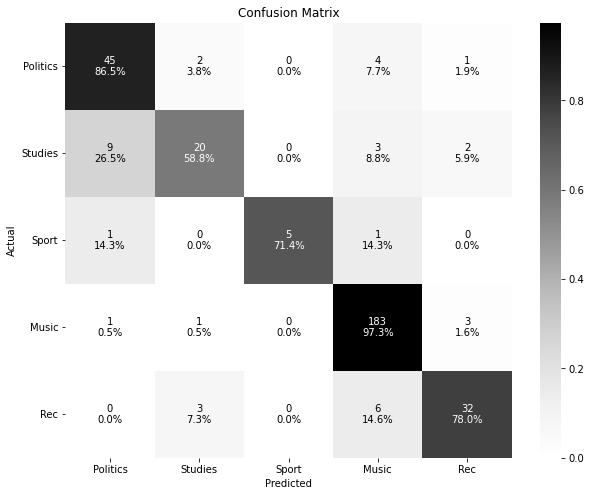

In [10]:
# Create a DataFrame from the confusion matrix
conf_df = pd.DataFrame(conf_matrix, columns=unique_classes, index=unique_classes)
# Normalize the confusion matrix by row (divide each row by the sum of its elements)
conf_df_norm = conf_df.div(conf_df.sum(axis=1), axis=0)
# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
# Nice cmap's: "Greys", "bone_r"
sns.heatmap(conf_df_norm, fmt="", cmap='Greys')
# Customize the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
# Add count and percentage below each cell
for i in range(conf_df_norm.shape[0]):
    for j in range(conf_df_norm.shape[1]):
        count = conf_df.iloc[i, j]
        percent = conf_df_norm.iloc[i, j]
        text = f"{count}\n{percent:.1%}"
        # Determine the text color based on the cell color
        text_color = 'white' if conf_df_norm.iloc[i, j] > 0.5 else 'black'
        # Set the text color in the plot
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=text_color)
# Show the plot
plt.show()

Now let's see what labels were assigned in df format

In [ ]:
# Assuming you have already trained your model and obtained the predicted labels
predicted_labels = svm.predict(tv_test_features)
# Create a new dataframe that contains the test data and the predicted labels
test_df = pd.DataFrame({'video_title': test_corpus, 'category': test_label_names, 'actual_label': test_label_nums, 'predicted_label': predicted_labels})
# Print the first 10 rows of the new dataframe
test_df.head(10)

,video_title,category,actual_label,predicted_label
0,french foreign legion trains uk troops tanks g...,Politics,2,Politics
1,economic war ukraine year energy war politics ...,Studies,3,Studies
2,ost disposal unitimperium mix kestrel,Music,0,Music
3,filmua group,Rec,1,Rec
4,panzerlied hearts iron 4 version german march ...,Music,0,Music
5,south korea wests new military megafactory chi...,Studies,3,Politics
6,m2a2 ods bradley militarnyi,Studies,3,Politics
7,sadsvit,Music,0,Music
8,need learn docker right docker containers 101 ...,Studies,3,Studies
9,riffmaster,Music,0,Music


Select 100 rows from the big df of like 3-4k rows to test how the model performs in production or whatever it's called

In [ ]:
# new rows were gotten with df.sample(n=600, random_state=42)
# random_state=42 because I want to get the same sample
# get the features for the new videos using the trained vectorizer
new_features = tv.transform(new_rows["preproc"])
# predict the category of the new videos using the trained LinearSVC
predicted_labels = svm.predict(new_features)
# add the predicted labels to the new_videos dataframe
new_rows['category'] = predicted_labels
new_rows

NameError: name 'new_rows' is not defined

In [ ]:
# new_rows.to_csv("tried_600-700.csv")